In [2]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from datasets import DatasetA, DatasetB, cfg
from datasets.base import collate_bb
import random

import random
import mlflow
import mlflow.pytorch
import subprocess

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = max(cfg.label_map.values()) + 1  # background + 24 chromosomes

ds_a = DatasetA(cfg.root_a_xml, cfg.root_a_img, cfg.label_map, cfg.max_size)
ds_b_train = DatasetB(cfg.root_b, "train", cfg.label_map, cfg.max_size)


/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [3]:
def augment_sample(img, target, p=0.5):
    # img: (C,H,W); target: {"boxes","labels","masks"?,"image_id"?}
    if random.random() >= p:
        return img, target

    boxes = target["boxes"].clone()
    labels = target["labels"]
    masks = target.get("masks", None)
    _, H, W = img.shape

    # horizontal flip
    img = torch.flip(img, dims=[2])

    x1 = boxes[:, 0].clone()
    x2 = boxes[:, 2].clone()
    boxes[:, 0] = W - x2
    boxes[:, 2] = W - x1

    if masks is not None:
        masks = torch.flip(masks, dims=[2])

    new_target = {
        "boxes": boxes,
        "labels": labels,
    }
    if masks is not None:
        new_target["masks"] = masks
    if "image_id" in target:
        new_target["image_id"] = target["image_id"]

    return img, new_target

def augment_batch(imgs, targets, p=0.5):
    out_imgs, out_targets = [], []
    for img, t in zip(imgs, targets):
        img2, t2 = augment_sample(img, t, p=p)
        out_imgs.append(img2)
        out_targets.append(t2)
    return out_imgs, out_targets

In [4]:
#mlflow.set_tracking_uri("file:///media/sdb1/mlflow")

In [5]:
def make_model():
    num_classes = max(cfg.label_map.values()) + 1  # background + 24 chromosomes

    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)

    return model


train_ds = ds_a

# for A + B:
# from torch.utils.data import ConcatDataset
# train_ds = ConcatDataset([ds_a, ds_b_train])

def make_dataloader(batch_size=4, num_workers=4):
    ds_a = DatasetA(cfg.root_a_xml, cfg.root_a_img, cfg.label_map, cfg.max_size)
    loader = DataLoader(
        ds_a,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_bb,
    )
    return loader

def make_test_loader_B(batch_size=1, num_workers=4):
    ds_b_test = DatasetB(cfg.root_b, "test", cfg.label_map, cfg.max_size)
    loader = DataLoader(
        ds_b_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_bb,
    )
    return ds_b_test, loader

def train_one_epoch(model, loader, optimizer, device, epoch):
    model.train()
    running = 0.0

    for it, (imgs, targets) in enumerate(loader):
        # CPU aug
        imgs, targets = augment_batch(imgs, targets, p=0.5)

        # move to device
        imgs = [img.to(device) for img in imgs]
        targets = [
            {k: (v.to(device) if isinstance(v, torch.Tensor) else v)
             for k, v in t.items()}
            for t in targets
        ]

        loss_dict = model(imgs, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item()

        if (it + 1) % 20 == 0 or (it + 1) == len(loader):
            print(
                f"epoch {epoch+1} iter {it+1}/{len(loader)} "
                f"loss={loss.item():.4f} "
                + " ".join(f"{k}={v.item():.4f}" for k, v in loss_dict.items())
            )

    epoch_loss = running / len(loader)
    print(f"epoch {epoch+1} avg_loss={epoch_loss:.4f}")
    return epoch_loss


def run_training(num_epochs=10, use_mlflow=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = make_dataloader(batch_size=4, num_workers=4)
    model = make_model().to(device)

    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=0.005,
        momentum=0.9,
        weight_decay=1e-4,
    )


    mlflow.set_experiment("karyo_instance_seg")
    ctx = mlflow.start_run()

    history = []
    with ctx:
        mlflow.log_param("batch_size", 4)
        mlflow.log_param("lr", 0.005)
        mlflow.log_param("weight_decay", 1e-4)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("model", "maskrcnn_resnet50_fpn")

    for epoch in range(num_epochs):
        epoch_loss = train_one_epoch(model, train_loader, optimizer, device, epoch)
        history.append(epoch_loss)
        mlflow.log_metric("train_loss", epoch_loss, step=epoch)
        mlflow.pytorch.log_model(model, "model")

    return model, device, history

def run_eval_on_B(model, device):
    ds_b_test, test_loader = make_test_loader_B(batch_size=1, num_workers=4)
    num_classes = max(cfg.label_map.values())  # 24
    mAP50, aps = evaluate_map(
        model, test_loader, device,
        num_classes=num_classes,
        iou_thresh=0.5,
        score_thresh=0.05,
    )
    return mAP50, aps

def main():
    model, device, history = run_training(num_epochs=10, use_mlflow=True)
    mAP50, aps = run_eval_on_B(model, device)
    print("final mAP@0.5:", mAP50)

#if __name__ == "__main__":
#    main()

In [8]:


model, device, hist = run_training(num_epochs=30, use_mlflow=True)

import numpy as np
mAP50, aps = run_eval_on_B(model, device)

epoch 1 iter 20/1250 loss=2.6136 loss_classifier=1.1061 loss_box_reg=0.7935 loss_mask=0.5800 loss_objectness=0.0363 loss_rpn_box_reg=0.0977
epoch 1 iter 40/1250 loss=2.4145 loss_classifier=1.0763 loss_box_reg=0.8317 loss_mask=0.3935 loss_objectness=0.0230 loss_rpn_box_reg=0.0900
epoch 1 iter 60/1250 loss=2.2371 loss_classifier=0.9998 loss_box_reg=0.7696 loss_mask=0.3789 loss_objectness=0.0195 loss_rpn_box_reg=0.0693
epoch 1 iter 80/1250 loss=2.1637 loss_classifier=0.9873 loss_box_reg=0.6989 loss_mask=0.3702 loss_objectness=0.0338 loss_rpn_box_reg=0.0735
epoch 1 iter 100/1250 loss=1.8210 loss_classifier=0.8896 loss_box_reg=0.5240 loss_mask=0.3508 loss_objectness=0.0103 loss_rpn_box_reg=0.0464
epoch 1 iter 120/1250 loss=1.7182 loss_classifier=0.9089 loss_box_reg=0.3804 loss_mask=0.3253 loss_objectness=0.0546 loss_rpn_box_reg=0.0491
epoch 1 iter 140/1250 loss=1.6882 loss_classifier=0.8658 loss_box_reg=0.4179 loss_mask=0.3426 loss_objectness=0.0158 loss_rpn_box_reg=0.0460
epoch 1 iter 160/

2025/12/03 15:53:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 2 iter 20/1250 loss=1.0210 loss_classifier=0.5237 loss_box_reg=0.2735 loss_mask=0.1917 loss_objectness=0.0046 loss_rpn_box_reg=0.0276
epoch 2 iter 40/1250 loss=1.0293 loss_classifier=0.5486 loss_box_reg=0.2346 loss_mask=0.2001 loss_objectness=0.0066 loss_rpn_box_reg=0.0395
epoch 2 iter 60/1250 loss=1.0618 loss_classifier=0.5420 loss_box_reg=0.2680 loss_mask=0.2084 loss_objectness=0.0052 loss_rpn_box_reg=0.0383
epoch 2 iter 80/1250 loss=1.0328 loss_classifier=0.5423 loss_box_reg=0.2498 loss_mask=0.2049 loss_objectness=0.0027 loss_rpn_box_reg=0.0329
epoch 2 iter 100/1250 loss=0.9279 loss_classifier=0.4876 loss_box_reg=0.2327 loss_mask=0.1805 loss_objectness=0.0023 loss_rpn_box_reg=0.0247
epoch 2 iter 120/1250 loss=1.0527 loss_classifier=0.5487 loss_box_reg=0.2728 loss_mask=0.1962 loss_objectness=0.0045 loss_rpn_box_reg=0.0305
epoch 2 iter 140/1250 loss=0.9998 loss_classifier=0.5396 loss_box_reg=0.2275 loss_mask=0.1945 loss_objectness=0.0100 loss_rpn_box_reg=0.0283
epoch 2 iter 160/

2025/12/03 16:05:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 3 iter 20/1250 loss=0.8882 loss_classifier=0.3812 loss_box_reg=0.2503 loss_mask=0.2095 loss_objectness=0.0037 loss_rpn_box_reg=0.0435
epoch 3 iter 40/1250 loss=0.7485 loss_classifier=0.3431 loss_box_reg=0.2039 loss_mask=0.1673 loss_objectness=0.0018 loss_rpn_box_reg=0.0324
epoch 3 iter 60/1250 loss=0.9995 loss_classifier=0.4752 loss_box_reg=0.2796 loss_mask=0.1993 loss_objectness=0.0052 loss_rpn_box_reg=0.0402
epoch 3 iter 80/1250 loss=0.7387 loss_classifier=0.3671 loss_box_reg=0.1861 loss_mask=0.1593 loss_objectness=0.0020 loss_rpn_box_reg=0.0242
epoch 3 iter 100/1250 loss=0.7042 loss_classifier=0.3198 loss_box_reg=0.2088 loss_mask=0.1501 loss_objectness=0.0058 loss_rpn_box_reg=0.0196
epoch 3 iter 120/1250 loss=0.7370 loss_classifier=0.3326 loss_box_reg=0.2009 loss_mask=0.1660 loss_objectness=0.0137 loss_rpn_box_reg=0.0239
epoch 3 iter 140/1250 loss=0.8883 loss_classifier=0.4193 loss_box_reg=0.2465 loss_mask=0.1765 loss_objectness=0.0066 loss_rpn_box_reg=0.0394
epoch 3 iter 160/

2025/12/03 16:17:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 4 iter 20/1250 loss=0.8166 loss_classifier=0.3519 loss_box_reg=0.2469 loss_mask=0.1767 loss_objectness=0.0052 loss_rpn_box_reg=0.0359
epoch 4 iter 40/1250 loss=0.5753 loss_classifier=0.2300 loss_box_reg=0.1686 loss_mask=0.1480 loss_objectness=0.0017 loss_rpn_box_reg=0.0271
epoch 4 iter 60/1250 loss=0.6408 loss_classifier=0.2516 loss_box_reg=0.2094 loss_mask=0.1522 loss_objectness=0.0013 loss_rpn_box_reg=0.0262
epoch 4 iter 80/1250 loss=0.7035 loss_classifier=0.3024 loss_box_reg=0.2150 loss_mask=0.1602 loss_objectness=0.0023 loss_rpn_box_reg=0.0235
epoch 4 iter 100/1250 loss=0.6166 loss_classifier=0.2406 loss_box_reg=0.2006 loss_mask=0.1470 loss_objectness=0.0034 loss_rpn_box_reg=0.0250
epoch 4 iter 120/1250 loss=0.5493 loss_classifier=0.2011 loss_box_reg=0.1785 loss_mask=0.1431 loss_objectness=0.0039 loss_rpn_box_reg=0.0227
epoch 4 iter 140/1250 loss=0.7078 loss_classifier=0.3430 loss_box_reg=0.1777 loss_mask=0.1498 loss_objectness=0.0099 loss_rpn_box_reg=0.0273
epoch 4 iter 160/

2025/12/03 16:29:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 5 iter 20/1250 loss=0.6402 loss_classifier=0.2547 loss_box_reg=0.1950 loss_mask=0.1626 loss_objectness=0.0048 loss_rpn_box_reg=0.0230
epoch 5 iter 40/1250 loss=0.5844 loss_classifier=0.1985 loss_box_reg=0.1954 loss_mask=0.1620 loss_objectness=0.0050 loss_rpn_box_reg=0.0234
epoch 5 iter 60/1250 loss=0.6481 loss_classifier=0.2353 loss_box_reg=0.2114 loss_mask=0.1652 loss_objectness=0.0050 loss_rpn_box_reg=0.0312
epoch 5 iter 80/1250 loss=0.6166 loss_classifier=0.2632 loss_box_reg=0.1775 loss_mask=0.1528 loss_objectness=0.0045 loss_rpn_box_reg=0.0186
epoch 5 iter 100/1250 loss=0.6260 loss_classifier=0.2522 loss_box_reg=0.1941 loss_mask=0.1499 loss_objectness=0.0035 loss_rpn_box_reg=0.0263
epoch 5 iter 120/1250 loss=0.4868 loss_classifier=0.1887 loss_box_reg=0.1444 loss_mask=0.1295 loss_objectness=0.0031 loss_rpn_box_reg=0.0212
epoch 5 iter 140/1250 loss=0.4785 loss_classifier=0.1879 loss_box_reg=0.1378 loss_mask=0.1359 loss_objectness=0.0026 loss_rpn_box_reg=0.0143
epoch 5 iter 160/

2025/12/03 16:41:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 6 iter 20/1250 loss=0.5626 loss_classifier=0.1974 loss_box_reg=0.2005 loss_mask=0.1381 loss_objectness=0.0013 loss_rpn_box_reg=0.0252
epoch 6 iter 40/1250 loss=0.5329 loss_classifier=0.1859 loss_box_reg=0.1761 loss_mask=0.1400 loss_objectness=0.0018 loss_rpn_box_reg=0.0290
epoch 6 iter 60/1250 loss=0.4489 loss_classifier=0.1470 loss_box_reg=0.1464 loss_mask=0.1319 loss_objectness=0.0023 loss_rpn_box_reg=0.0213
epoch 6 iter 80/1250 loss=0.5094 loss_classifier=0.1713 loss_box_reg=0.1727 loss_mask=0.1483 loss_objectness=0.0008 loss_rpn_box_reg=0.0164
epoch 6 iter 100/1250 loss=0.5541 loss_classifier=0.1869 loss_box_reg=0.1968 loss_mask=0.1453 loss_objectness=0.0043 loss_rpn_box_reg=0.0208
epoch 6 iter 120/1250 loss=0.6348 loss_classifier=0.2183 loss_box_reg=0.2322 loss_mask=0.1478 loss_objectness=0.0019 loss_rpn_box_reg=0.0346
epoch 6 iter 140/1250 loss=0.5541 loss_classifier=0.1759 loss_box_reg=0.1944 loss_mask=0.1592 loss_objectness=0.0019 loss_rpn_box_reg=0.0228
epoch 6 iter 160/

2025/12/03 17:04:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 8 iter 20/1250 loss=0.5048 loss_classifier=0.1514 loss_box_reg=0.1850 loss_mask=0.1454 loss_objectness=0.0021 loss_rpn_box_reg=0.0210
epoch 8 iter 40/1250 loss=0.5892 loss_classifier=0.2209 loss_box_reg=0.1957 loss_mask=0.1469 loss_objectness=0.0033 loss_rpn_box_reg=0.0225
epoch 8 iter 60/1250 loss=0.4306 loss_classifier=0.1110 loss_box_reg=0.1625 loss_mask=0.1367 loss_objectness=0.0007 loss_rpn_box_reg=0.0197
epoch 8 iter 80/1250 loss=0.4063 loss_classifier=0.1123 loss_box_reg=0.1398 loss_mask=0.1315 loss_objectness=0.0024 loss_rpn_box_reg=0.0203
epoch 8 iter 100/1250 loss=0.4354 loss_classifier=0.1456 loss_box_reg=0.1411 loss_mask=0.1288 loss_objectness=0.0050 loss_rpn_box_reg=0.0149
epoch 8 iter 120/1250 loss=0.4864 loss_classifier=0.1690 loss_box_reg=0.1631 loss_mask=0.1350 loss_objectness=0.0008 loss_rpn_box_reg=0.0185
epoch 8 iter 140/1250 loss=0.5405 loss_classifier=0.1858 loss_box_reg=0.1831 loss_mask=0.1405 loss_objectness=0.0055 loss_rpn_box_reg=0.0257
epoch 8 iter 160/

2025/12/03 17:16:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 9 iter 20/1250 loss=0.4205 loss_classifier=0.1409 loss_box_reg=0.1341 loss_mask=0.1276 loss_objectness=0.0014 loss_rpn_box_reg=0.0165
epoch 9 iter 40/1250 loss=0.4287 loss_classifier=0.1300 loss_box_reg=0.1550 loss_mask=0.1245 loss_objectness=0.0016 loss_rpn_box_reg=0.0176
epoch 9 iter 60/1250 loss=0.4563 loss_classifier=0.1162 loss_box_reg=0.1802 loss_mask=0.1352 loss_objectness=0.0019 loss_rpn_box_reg=0.0228
epoch 9 iter 80/1250 loss=0.4260 loss_classifier=0.1533 loss_box_reg=0.1365 loss_mask=0.1228 loss_objectness=0.0013 loss_rpn_box_reg=0.0120
epoch 9 iter 100/1250 loss=0.4121 loss_classifier=0.1012 loss_box_reg=0.1610 loss_mask=0.1310 loss_objectness=0.0007 loss_rpn_box_reg=0.0183
epoch 9 iter 120/1250 loss=0.3988 loss_classifier=0.1280 loss_box_reg=0.1322 loss_mask=0.1209 loss_objectness=0.0009 loss_rpn_box_reg=0.0168
epoch 9 iter 140/1250 loss=0.4568 loss_classifier=0.1358 loss_box_reg=0.1633 loss_mask=0.1333 loss_objectness=0.0013 loss_rpn_box_reg=0.0231
epoch 9 iter 160/

2025/12/03 17:28:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 10 iter 20/1250 loss=0.5096 loss_classifier=0.1960 loss_box_reg=0.1649 loss_mask=0.1343 loss_objectness=0.0003 loss_rpn_box_reg=0.0143
epoch 10 iter 40/1250 loss=0.4306 loss_classifier=0.1291 loss_box_reg=0.1495 loss_mask=0.1322 loss_objectness=0.0027 loss_rpn_box_reg=0.0170
epoch 10 iter 60/1250 loss=0.3985 loss_classifier=0.1186 loss_box_reg=0.1445 loss_mask=0.1200 loss_objectness=0.0006 loss_rpn_box_reg=0.0148
epoch 10 iter 80/1250 loss=0.4128 loss_classifier=0.1397 loss_box_reg=0.1365 loss_mask=0.1202 loss_objectness=0.0013 loss_rpn_box_reg=0.0152
epoch 10 iter 100/1250 loss=0.4438 loss_classifier=0.1296 loss_box_reg=0.1525 loss_mask=0.1439 loss_objectness=0.0027 loss_rpn_box_reg=0.0151
epoch 10 iter 120/1250 loss=0.3573 loss_classifier=0.1165 loss_box_reg=0.1134 loss_mask=0.1108 loss_objectness=0.0020 loss_rpn_box_reg=0.0146
epoch 10 iter 140/1250 loss=0.4892 loss_classifier=0.1586 loss_box_reg=0.1679 loss_mask=0.1407 loss_objectness=0.0020 loss_rpn_box_reg=0.0199
epoch 10 i

2025/12/03 17:40:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 11 iter 20/1250 loss=0.4927 loss_classifier=0.1198 loss_box_reg=0.1985 loss_mask=0.1526 loss_objectness=0.0007 loss_rpn_box_reg=0.0210
epoch 11 iter 40/1250 loss=0.3872 loss_classifier=0.0892 loss_box_reg=0.1474 loss_mask=0.1320 loss_objectness=0.0010 loss_rpn_box_reg=0.0176
epoch 11 iter 60/1250 loss=0.3319 loss_classifier=0.0926 loss_box_reg=0.1178 loss_mask=0.1064 loss_objectness=0.0016 loss_rpn_box_reg=0.0136
epoch 11 iter 80/1250 loss=0.4436 loss_classifier=0.1413 loss_box_reg=0.1522 loss_mask=0.1318 loss_objectness=0.0016 loss_rpn_box_reg=0.0167
epoch 11 iter 100/1250 loss=0.3683 loss_classifier=0.0979 loss_box_reg=0.1388 loss_mask=0.1149 loss_objectness=0.0003 loss_rpn_box_reg=0.0163
epoch 11 iter 120/1250 loss=0.4382 loss_classifier=0.1107 loss_box_reg=0.1815 loss_mask=0.1287 loss_objectness=0.0010 loss_rpn_box_reg=0.0162
epoch 11 iter 140/1250 loss=0.5513 loss_classifier=0.1711 loss_box_reg=0.2003 loss_mask=0.1513 loss_objectness=0.0041 loss_rpn_box_reg=0.0246
epoch 11 i

2025/12/03 17:52:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 12 iter 20/1250 loss=0.3831 loss_classifier=0.1086 loss_box_reg=0.1392 loss_mask=0.1188 loss_objectness=0.0003 loss_rpn_box_reg=0.0161
epoch 12 iter 40/1250 loss=0.3810 loss_classifier=0.0928 loss_box_reg=0.1558 loss_mask=0.1148 loss_objectness=0.0004 loss_rpn_box_reg=0.0172
epoch 12 iter 60/1250 loss=0.5742 loss_classifier=0.2297 loss_box_reg=0.1816 loss_mask=0.1403 loss_objectness=0.0007 loss_rpn_box_reg=0.0218
epoch 12 iter 80/1250 loss=0.4565 loss_classifier=0.1488 loss_box_reg=0.1667 loss_mask=0.1187 loss_objectness=0.0004 loss_rpn_box_reg=0.0219
epoch 12 iter 100/1250 loss=0.5508 loss_classifier=0.1422 loss_box_reg=0.2182 loss_mask=0.1552 loss_objectness=0.0045 loss_rpn_box_reg=0.0306
epoch 12 iter 120/1250 loss=0.4909 loss_classifier=0.1211 loss_box_reg=0.1937 loss_mask=0.1498 loss_objectness=0.0010 loss_rpn_box_reg=0.0253
epoch 12 iter 140/1250 loss=0.3836 loss_classifier=0.1105 loss_box_reg=0.1295 loss_mask=0.1256 loss_objectness=0.0070 loss_rpn_box_reg=0.0109
epoch 12 i

2025/12/03 18:04:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 13 iter 20/1250 loss=0.4549 loss_classifier=0.1392 loss_box_reg=0.1587 loss_mask=0.1325 loss_objectness=0.0013 loss_rpn_box_reg=0.0232
epoch 13 iter 40/1250 loss=0.4103 loss_classifier=0.1356 loss_box_reg=0.1385 loss_mask=0.1188 loss_objectness=0.0012 loss_rpn_box_reg=0.0161
epoch 13 iter 60/1250 loss=0.4168 loss_classifier=0.1089 loss_box_reg=0.1588 loss_mask=0.1307 loss_objectness=0.0005 loss_rpn_box_reg=0.0180
epoch 13 iter 80/1250 loss=0.3620 loss_classifier=0.0968 loss_box_reg=0.1306 loss_mask=0.1187 loss_objectness=0.0003 loss_rpn_box_reg=0.0156
epoch 13 iter 100/1250 loss=0.4576 loss_classifier=0.1367 loss_box_reg=0.1666 loss_mask=0.1357 loss_objectness=0.0007 loss_rpn_box_reg=0.0180
epoch 13 iter 120/1250 loss=0.3409 loss_classifier=0.0912 loss_box_reg=0.1248 loss_mask=0.1088 loss_objectness=0.0010 loss_rpn_box_reg=0.0151
epoch 13 iter 140/1250 loss=0.3632 loss_classifier=0.1055 loss_box_reg=0.1280 loss_mask=0.1162 loss_objectness=0.0004 loss_rpn_box_reg=0.0132
epoch 13 i

2025/12/03 18:15:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 14 iter 20/1250 loss=0.4287 loss_classifier=0.1072 loss_box_reg=0.1623 loss_mask=0.1380 loss_objectness=0.0011 loss_rpn_box_reg=0.0202
epoch 14 iter 40/1250 loss=0.4745 loss_classifier=0.1278 loss_box_reg=0.1910 loss_mask=0.1304 loss_objectness=0.0017 loss_rpn_box_reg=0.0236
epoch 14 iter 60/1250 loss=0.4038 loss_classifier=0.1082 loss_box_reg=0.1513 loss_mask=0.1267 loss_objectness=0.0005 loss_rpn_box_reg=0.0170
epoch 14 iter 80/1250 loss=0.3966 loss_classifier=0.1011 loss_box_reg=0.1579 loss_mask=0.1214 loss_objectness=0.0007 loss_rpn_box_reg=0.0156
epoch 14 iter 100/1250 loss=0.4245 loss_classifier=0.1075 loss_box_reg=0.1720 loss_mask=0.1273 loss_objectness=0.0005 loss_rpn_box_reg=0.0172
epoch 14 iter 120/1250 loss=0.3215 loss_classifier=0.0880 loss_box_reg=0.1180 loss_mask=0.1035 loss_objectness=0.0004 loss_rpn_box_reg=0.0116
epoch 14 iter 140/1250 loss=0.3387 loss_classifier=0.0967 loss_box_reg=0.1164 loss_mask=0.1089 loss_objectness=0.0007 loss_rpn_box_reg=0.0160
epoch 14 i

2025/12/03 18:27:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 15 iter 20/1250 loss=0.3408 loss_classifier=0.0925 loss_box_reg=0.1235 loss_mask=0.1070 loss_objectness=0.0010 loss_rpn_box_reg=0.0168
epoch 15 iter 40/1250 loss=0.3857 loss_classifier=0.1086 loss_box_reg=0.1429 loss_mask=0.1157 loss_objectness=0.0009 loss_rpn_box_reg=0.0175
epoch 15 iter 60/1250 loss=0.3389 loss_classifier=0.0830 loss_box_reg=0.1269 loss_mask=0.1117 loss_objectness=0.0016 loss_rpn_box_reg=0.0156
epoch 15 iter 80/1250 loss=0.3978 loss_classifier=0.1114 loss_box_reg=0.1463 loss_mask=0.1213 loss_objectness=0.0009 loss_rpn_box_reg=0.0180
epoch 15 iter 100/1250 loss=0.4378 loss_classifier=0.1242 loss_box_reg=0.1525 loss_mask=0.1433 loss_objectness=0.0006 loss_rpn_box_reg=0.0171
epoch 15 iter 120/1250 loss=0.3837 loss_classifier=0.1042 loss_box_reg=0.1405 loss_mask=0.1195 loss_objectness=0.0010 loss_rpn_box_reg=0.0186
epoch 15 iter 140/1250 loss=0.3859 loss_classifier=0.0967 loss_box_reg=0.1523 loss_mask=0.1177 loss_objectness=0.0005 loss_rpn_box_reg=0.0186
epoch 15 i

2025/12/03 18:39:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 16 iter 20/1250 loss=0.3387 loss_classifier=0.0849 loss_box_reg=0.1267 loss_mask=0.1117 loss_objectness=0.0003 loss_rpn_box_reg=0.0152
epoch 16 iter 40/1250 loss=0.3667 loss_classifier=0.0973 loss_box_reg=0.1353 loss_mask=0.1170 loss_objectness=0.0025 loss_rpn_box_reg=0.0146
epoch 16 iter 60/1250 loss=0.4299 loss_classifier=0.0990 loss_box_reg=0.1772 loss_mask=0.1350 loss_objectness=0.0010 loss_rpn_box_reg=0.0176
epoch 16 iter 80/1250 loss=0.4046 loss_classifier=0.1058 loss_box_reg=0.1563 loss_mask=0.1237 loss_objectness=0.0009 loss_rpn_box_reg=0.0179
epoch 16 iter 100/1250 loss=0.3024 loss_classifier=0.0770 loss_box_reg=0.1064 loss_mask=0.1085 loss_objectness=0.0007 loss_rpn_box_reg=0.0097
epoch 16 iter 120/1250 loss=0.4685 loss_classifier=0.1211 loss_box_reg=0.1813 loss_mask=0.1423 loss_objectness=0.0019 loss_rpn_box_reg=0.0219
epoch 16 iter 140/1250 loss=0.4807 loss_classifier=0.1316 loss_box_reg=0.1889 loss_mask=0.1366 loss_objectness=0.0007 loss_rpn_box_reg=0.0228
epoch 16 i

2025/12/03 18:51:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 17 iter 20/1250 loss=0.3664 loss_classifier=0.0942 loss_box_reg=0.1440 loss_mask=0.1068 loss_objectness=0.0014 loss_rpn_box_reg=0.0200
epoch 17 iter 40/1250 loss=0.3141 loss_classifier=0.0880 loss_box_reg=0.1003 loss_mask=0.1077 loss_objectness=0.0014 loss_rpn_box_reg=0.0166
epoch 17 iter 60/1250 loss=0.3142 loss_classifier=0.0890 loss_box_reg=0.1048 loss_mask=0.1078 loss_objectness=0.0006 loss_rpn_box_reg=0.0119
epoch 17 iter 80/1250 loss=0.3451 loss_classifier=0.0868 loss_box_reg=0.1298 loss_mask=0.1139 loss_objectness=0.0006 loss_rpn_box_reg=0.0140
epoch 17 iter 100/1250 loss=0.3401 loss_classifier=0.0984 loss_box_reg=0.1156 loss_mask=0.1128 loss_objectness=0.0003 loss_rpn_box_reg=0.0130
epoch 17 iter 120/1250 loss=0.3428 loss_classifier=0.0861 loss_box_reg=0.1323 loss_mask=0.1110 loss_objectness=0.0013 loss_rpn_box_reg=0.0121
epoch 17 iter 140/1250 loss=0.3894 loss_classifier=0.0867 loss_box_reg=0.1429 loss_mask=0.1285 loss_objectness=0.0006 loss_rpn_box_reg=0.0307
epoch 17 i

2025/12/03 19:03:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 18 iter 20/1250 loss=0.3805 loss_classifier=0.0766 loss_box_reg=0.1608 loss_mask=0.1296 loss_objectness=0.0011 loss_rpn_box_reg=0.0124
epoch 18 iter 40/1250 loss=0.4226 loss_classifier=0.1133 loss_box_reg=0.1595 loss_mask=0.1316 loss_objectness=0.0012 loss_rpn_box_reg=0.0171
epoch 18 iter 60/1250 loss=0.3863 loss_classifier=0.1129 loss_box_reg=0.1364 loss_mask=0.1171 loss_objectness=0.0006 loss_rpn_box_reg=0.0193
epoch 18 iter 80/1250 loss=0.4839 loss_classifier=0.1068 loss_box_reg=0.1868 loss_mask=0.1607 loss_objectness=0.0024 loss_rpn_box_reg=0.0272
epoch 18 iter 100/1250 loss=0.4227 loss_classifier=0.1072 loss_box_reg=0.1592 loss_mask=0.1367 loss_objectness=0.0005 loss_rpn_box_reg=0.0191
epoch 18 iter 120/1250 loss=0.3875 loss_classifier=0.0970 loss_box_reg=0.1460 loss_mask=0.1262 loss_objectness=0.0009 loss_rpn_box_reg=0.0172
epoch 18 iter 140/1250 loss=0.3291 loss_classifier=0.0982 loss_box_reg=0.1158 loss_mask=0.1011 loss_objectness=0.0004 loss_rpn_box_reg=0.0136
epoch 18 i

2025/12/03 19:15:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 19 iter 20/1250 loss=0.3070 loss_classifier=0.0752 loss_box_reg=0.1086 loss_mask=0.1103 loss_objectness=0.0006 loss_rpn_box_reg=0.0124
epoch 19 iter 40/1250 loss=0.4030 loss_classifier=0.1087 loss_box_reg=0.1500 loss_mask=0.1224 loss_objectness=0.0004 loss_rpn_box_reg=0.0216
epoch 19 iter 60/1250 loss=0.3560 loss_classifier=0.0905 loss_box_reg=0.1284 loss_mask=0.1181 loss_objectness=0.0003 loss_rpn_box_reg=0.0186
epoch 19 iter 80/1250 loss=0.4019 loss_classifier=0.0948 loss_box_reg=0.1600 loss_mask=0.1268 loss_objectness=0.0004 loss_rpn_box_reg=0.0200
epoch 19 iter 100/1250 loss=0.3332 loss_classifier=0.0809 loss_box_reg=0.1286 loss_mask=0.1091 loss_objectness=0.0004 loss_rpn_box_reg=0.0142
epoch 19 iter 120/1250 loss=0.3811 loss_classifier=0.1043 loss_box_reg=0.1403 loss_mask=0.1175 loss_objectness=0.0010 loss_rpn_box_reg=0.0181
epoch 19 iter 140/1250 loss=0.3494 loss_classifier=0.0859 loss_box_reg=0.1346 loss_mask=0.1173 loss_objectness=0.0004 loss_rpn_box_reg=0.0112
epoch 19 i

2025/12/03 19:27:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 20 iter 20/1250 loss=0.2441 loss_classifier=0.0635 loss_box_reg=0.0831 loss_mask=0.0892 loss_objectness=0.0003 loss_rpn_box_reg=0.0079
epoch 20 iter 40/1250 loss=0.2949 loss_classifier=0.0771 loss_box_reg=0.0975 loss_mask=0.1086 loss_objectness=0.0003 loss_rpn_box_reg=0.0114
epoch 20 iter 60/1250 loss=0.3276 loss_classifier=0.0888 loss_box_reg=0.1184 loss_mask=0.1048 loss_objectness=0.0006 loss_rpn_box_reg=0.0149
epoch 20 iter 80/1250 loss=0.3705 loss_classifier=0.0964 loss_box_reg=0.1342 loss_mask=0.1204 loss_objectness=0.0007 loss_rpn_box_reg=0.0188
epoch 20 iter 100/1250 loss=0.3753 loss_classifier=0.0729 loss_box_reg=0.1540 loss_mask=0.1294 loss_objectness=0.0004 loss_rpn_box_reg=0.0187
epoch 20 iter 120/1250 loss=0.2823 loss_classifier=0.0637 loss_box_reg=0.0993 loss_mask=0.1072 loss_objectness=0.0006 loss_rpn_box_reg=0.0114
epoch 20 iter 140/1250 loss=0.3883 loss_classifier=0.0887 loss_box_reg=0.1516 loss_mask=0.1313 loss_objectness=0.0010 loss_rpn_box_reg=0.0156
epoch 20 i

2025/12/03 19:38:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 21 iter 20/1250 loss=0.3405 loss_classifier=0.0969 loss_box_reg=0.1208 loss_mask=0.1106 loss_objectness=0.0005 loss_rpn_box_reg=0.0117
epoch 21 iter 40/1250 loss=0.3414 loss_classifier=0.0943 loss_box_reg=0.1294 loss_mask=0.1054 loss_objectness=0.0004 loss_rpn_box_reg=0.0119
epoch 21 iter 60/1250 loss=0.3975 loss_classifier=0.1101 loss_box_reg=0.1544 loss_mask=0.1140 loss_objectness=0.0004 loss_rpn_box_reg=0.0185
epoch 21 iter 80/1250 loss=0.4314 loss_classifier=0.1022 loss_box_reg=0.1799 loss_mask=0.1255 loss_objectness=0.0004 loss_rpn_box_reg=0.0234
epoch 21 iter 100/1250 loss=0.3397 loss_classifier=0.0798 loss_box_reg=0.1280 loss_mask=0.1175 loss_objectness=0.0004 loss_rpn_box_reg=0.0140
epoch 21 iter 120/1250 loss=0.3465 loss_classifier=0.1116 loss_box_reg=0.1154 loss_mask=0.1063 loss_objectness=0.0006 loss_rpn_box_reg=0.0126
epoch 21 iter 140/1250 loss=0.3140 loss_classifier=0.0792 loss_box_reg=0.1148 loss_mask=0.1056 loss_objectness=0.0003 loss_rpn_box_reg=0.0142
epoch 21 i

2025/12/03 19:50:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 22 iter 20/1250 loss=0.3163 loss_classifier=0.0704 loss_box_reg=0.1065 loss_mask=0.1200 loss_objectness=0.0022 loss_rpn_box_reg=0.0174
epoch 22 iter 40/1250 loss=0.3224 loss_classifier=0.0887 loss_box_reg=0.1129 loss_mask=0.1070 loss_objectness=0.0006 loss_rpn_box_reg=0.0132
epoch 22 iter 60/1250 loss=0.3069 loss_classifier=0.0818 loss_box_reg=0.1113 loss_mask=0.1010 loss_objectness=0.0008 loss_rpn_box_reg=0.0120
epoch 22 iter 80/1250 loss=0.3340 loss_classifier=0.0843 loss_box_reg=0.1261 loss_mask=0.1109 loss_objectness=0.0006 loss_rpn_box_reg=0.0121
epoch 22 iter 100/1250 loss=0.3133 loss_classifier=0.0881 loss_box_reg=0.1089 loss_mask=0.1063 loss_objectness=0.0012 loss_rpn_box_reg=0.0088
epoch 22 iter 120/1250 loss=0.3290 loss_classifier=0.0847 loss_box_reg=0.1260 loss_mask=0.1056 loss_objectness=0.0004 loss_rpn_box_reg=0.0124
epoch 22 iter 140/1250 loss=0.2900 loss_classifier=0.0762 loss_box_reg=0.1022 loss_mask=0.1009 loss_objectness=0.0003 loss_rpn_box_reg=0.0103
epoch 22 i

2025/12/03 20:02:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 23 iter 20/1250 loss=0.3262 loss_classifier=0.0811 loss_box_reg=0.1241 loss_mask=0.1078 loss_objectness=0.0004 loss_rpn_box_reg=0.0128
epoch 23 iter 40/1250 loss=0.3175 loss_classifier=0.0745 loss_box_reg=0.1135 loss_mask=0.1153 loss_objectness=0.0003 loss_rpn_box_reg=0.0139
epoch 23 iter 60/1250 loss=0.3314 loss_classifier=0.0622 loss_box_reg=0.1406 loss_mask=0.1135 loss_objectness=0.0007 loss_rpn_box_reg=0.0144
epoch 23 iter 80/1250 loss=0.3684 loss_classifier=0.0754 loss_box_reg=0.1461 loss_mask=0.1300 loss_objectness=0.0003 loss_rpn_box_reg=0.0167
epoch 23 iter 100/1250 loss=0.4702 loss_classifier=0.1237 loss_box_reg=0.1900 loss_mask=0.1355 loss_objectness=0.0003 loss_rpn_box_reg=0.0206
epoch 23 iter 120/1250 loss=0.3117 loss_classifier=0.0819 loss_box_reg=0.1160 loss_mask=0.1037 loss_objectness=0.0003 loss_rpn_box_reg=0.0098
epoch 23 iter 140/1250 loss=0.3402 loss_classifier=0.0761 loss_box_reg=0.1292 loss_mask=0.1200 loss_objectness=0.0016 loss_rpn_box_reg=0.0134
epoch 23 i

2025/12/03 20:14:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 24 iter 20/1250 loss=0.3419 loss_classifier=0.0812 loss_box_reg=0.1323 loss_mask=0.1154 loss_objectness=0.0007 loss_rpn_box_reg=0.0124
epoch 24 iter 40/1250 loss=0.3450 loss_classifier=0.0690 loss_box_reg=0.1375 loss_mask=0.1239 loss_objectness=0.0002 loss_rpn_box_reg=0.0144
epoch 24 iter 60/1250 loss=0.2969 loss_classifier=0.0632 loss_box_reg=0.1213 loss_mask=0.0999 loss_objectness=0.0003 loss_rpn_box_reg=0.0123
epoch 24 iter 80/1250 loss=0.2937 loss_classifier=0.0746 loss_box_reg=0.1006 loss_mask=0.1060 loss_objectness=0.0010 loss_rpn_box_reg=0.0115
epoch 24 iter 100/1250 loss=0.4062 loss_classifier=0.0881 loss_box_reg=0.1694 loss_mask=0.1284 loss_objectness=0.0018 loss_rpn_box_reg=0.0185
epoch 24 iter 120/1250 loss=0.3430 loss_classifier=0.0778 loss_box_reg=0.1367 loss_mask=0.1174 loss_objectness=0.0002 loss_rpn_box_reg=0.0109
epoch 24 iter 140/1250 loss=0.3442 loss_classifier=0.0870 loss_box_reg=0.1251 loss_mask=0.1165 loss_objectness=0.0008 loss_rpn_box_reg=0.0148
epoch 24 i

2025/12/03 20:26:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 25 iter 20/1250 loss=0.3611 loss_classifier=0.0920 loss_box_reg=0.1391 loss_mask=0.1152 loss_objectness=0.0010 loss_rpn_box_reg=0.0139
epoch 25 iter 40/1250 loss=0.2872 loss_classifier=0.0699 loss_box_reg=0.1059 loss_mask=0.0981 loss_objectness=0.0011 loss_rpn_box_reg=0.0121
epoch 25 iter 60/1250 loss=0.3134 loss_classifier=0.0742 loss_box_reg=0.1208 loss_mask=0.1058 loss_objectness=0.0003 loss_rpn_box_reg=0.0123
epoch 25 iter 80/1250 loss=0.2730 loss_classifier=0.0625 loss_box_reg=0.0961 loss_mask=0.1034 loss_objectness=0.0004 loss_rpn_box_reg=0.0108
epoch 25 iter 100/1250 loss=0.3258 loss_classifier=0.0730 loss_box_reg=0.1291 loss_mask=0.1083 loss_objectness=0.0015 loss_rpn_box_reg=0.0140
epoch 25 iter 120/1250 loss=0.4154 loss_classifier=0.1046 loss_box_reg=0.1619 loss_mask=0.1277 loss_objectness=0.0017 loss_rpn_box_reg=0.0195
epoch 25 iter 140/1250 loss=0.2715 loss_classifier=0.0638 loss_box_reg=0.0916 loss_mask=0.1032 loss_objectness=0.0002 loss_rpn_box_reg=0.0126
epoch 25 i

2025/12/03 20:38:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 26 iter 20/1250 loss=0.3070 loss_classifier=0.0589 loss_box_reg=0.1268 loss_mask=0.1098 loss_objectness=0.0003 loss_rpn_box_reg=0.0112
epoch 26 iter 40/1250 loss=0.3998 loss_classifier=0.0998 loss_box_reg=0.1513 loss_mask=0.1284 loss_objectness=0.0007 loss_rpn_box_reg=0.0196
epoch 26 iter 60/1250 loss=0.3413 loss_classifier=0.0968 loss_box_reg=0.1219 loss_mask=0.1087 loss_objectness=0.0004 loss_rpn_box_reg=0.0134
epoch 26 iter 80/1250 loss=0.2722 loss_classifier=0.0736 loss_box_reg=0.0912 loss_mask=0.0952 loss_objectness=0.0004 loss_rpn_box_reg=0.0117
epoch 26 iter 100/1250 loss=0.3435 loss_classifier=0.0702 loss_box_reg=0.1329 loss_mask=0.1231 loss_objectness=0.0007 loss_rpn_box_reg=0.0166
epoch 26 iter 120/1250 loss=0.2771 loss_classifier=0.0607 loss_box_reg=0.0964 loss_mask=0.1056 loss_objectness=0.0004 loss_rpn_box_reg=0.0138
epoch 26 iter 140/1250 loss=0.3564 loss_classifier=0.0767 loss_box_reg=0.1444 loss_mask=0.1170 loss_objectness=0.0048 loss_rpn_box_reg=0.0135
epoch 26 i

2025/12/03 20:49:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 27 iter 20/1250 loss=0.4224 loss_classifier=0.1264 loss_box_reg=0.1555 loss_mask=0.1230 loss_objectness=0.0006 loss_rpn_box_reg=0.0170
epoch 27 iter 40/1250 loss=0.3945 loss_classifier=0.1028 loss_box_reg=0.1589 loss_mask=0.1122 loss_objectness=0.0006 loss_rpn_box_reg=0.0199
epoch 27 iter 60/1250 loss=0.3857 loss_classifier=0.0873 loss_box_reg=0.1600 loss_mask=0.1192 loss_objectness=0.0005 loss_rpn_box_reg=0.0188
epoch 27 iter 80/1250 loss=0.3979 loss_classifier=0.0928 loss_box_reg=0.1735 loss_mask=0.1163 loss_objectness=0.0009 loss_rpn_box_reg=0.0143
epoch 27 iter 100/1250 loss=0.3163 loss_classifier=0.0769 loss_box_reg=0.1171 loss_mask=0.1106 loss_objectness=0.0009 loss_rpn_box_reg=0.0108
epoch 27 iter 120/1250 loss=0.2911 loss_classifier=0.0677 loss_box_reg=0.1086 loss_mask=0.1019 loss_objectness=0.0011 loss_rpn_box_reg=0.0117
epoch 27 iter 140/1250 loss=0.2848 loss_classifier=0.0706 loss_box_reg=0.1125 loss_mask=0.0927 loss_objectness=0.0002 loss_rpn_box_reg=0.0088
epoch 27 i

2025/12/03 21:01:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 28 iter 20/1250 loss=0.2730 loss_classifier=0.0651 loss_box_reg=0.0926 loss_mask=0.1020 loss_objectness=0.0003 loss_rpn_box_reg=0.0130
epoch 28 iter 40/1250 loss=0.3036 loss_classifier=0.0773 loss_box_reg=0.1115 loss_mask=0.1016 loss_objectness=0.0008 loss_rpn_box_reg=0.0123
epoch 28 iter 60/1250 loss=0.3222 loss_classifier=0.0827 loss_box_reg=0.1207 loss_mask=0.1049 loss_objectness=0.0014 loss_rpn_box_reg=0.0124
epoch 28 iter 80/1250 loss=0.3758 loss_classifier=0.0945 loss_box_reg=0.1410 loss_mask=0.1246 loss_objectness=0.0005 loss_rpn_box_reg=0.0152
epoch 28 iter 100/1250 loss=0.3284 loss_classifier=0.0760 loss_box_reg=0.1182 loss_mask=0.1150 loss_objectness=0.0008 loss_rpn_box_reg=0.0185
epoch 28 iter 120/1250 loss=0.2975 loss_classifier=0.0660 loss_box_reg=0.1151 loss_mask=0.1036 loss_objectness=0.0003 loss_rpn_box_reg=0.0125
epoch 28 iter 140/1250 loss=0.3071 loss_classifier=0.0865 loss_box_reg=0.1056 loss_mask=0.1021 loss_objectness=0.0004 loss_rpn_box_reg=0.0125
epoch 28 i

2025/12/03 21:13:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 29 iter 20/1250 loss=0.3060 loss_classifier=0.0744 loss_box_reg=0.1127 loss_mask=0.1080 loss_objectness=0.0003 loss_rpn_box_reg=0.0106
epoch 29 iter 40/1250 loss=0.2647 loss_classifier=0.0658 loss_box_reg=0.0929 loss_mask=0.0960 loss_objectness=0.0003 loss_rpn_box_reg=0.0097
epoch 29 iter 60/1250 loss=0.3141 loss_classifier=0.0872 loss_box_reg=0.1141 loss_mask=0.0997 loss_objectness=0.0005 loss_rpn_box_reg=0.0125
epoch 29 iter 80/1250 loss=0.3206 loss_classifier=0.0818 loss_box_reg=0.1187 loss_mask=0.1056 loss_objectness=0.0003 loss_rpn_box_reg=0.0141
epoch 29 iter 100/1250 loss=0.3229 loss_classifier=0.0630 loss_box_reg=0.1357 loss_mask=0.1113 loss_objectness=0.0008 loss_rpn_box_reg=0.0121
epoch 29 iter 120/1250 loss=0.3336 loss_classifier=0.0706 loss_box_reg=0.1320 loss_mask=0.1147 loss_objectness=0.0004 loss_rpn_box_reg=0.0159
epoch 29 iter 140/1250 loss=0.3367 loss_classifier=0.0820 loss_box_reg=0.1217 loss_mask=0.1148 loss_objectness=0.0016 loss_rpn_box_reg=0.0166
epoch 29 i

2025/12/03 21:25:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


epoch 30 iter 20/1250 loss=0.3096 loss_classifier=0.0678 loss_box_reg=0.1174 loss_mask=0.1099 loss_objectness=0.0002 loss_rpn_box_reg=0.0142
epoch 30 iter 40/1250 loss=0.3521 loss_classifier=0.0893 loss_box_reg=0.1283 loss_mask=0.1171 loss_objectness=0.0003 loss_rpn_box_reg=0.0170
epoch 30 iter 60/1250 loss=0.3694 loss_classifier=0.1033 loss_box_reg=0.1265 loss_mask=0.1210 loss_objectness=0.0004 loss_rpn_box_reg=0.0182
epoch 30 iter 80/1250 loss=0.2905 loss_classifier=0.0782 loss_box_reg=0.1049 loss_mask=0.0913 loss_objectness=0.0038 loss_rpn_box_reg=0.0122
epoch 30 iter 100/1250 loss=0.3476 loss_classifier=0.0857 loss_box_reg=0.1398 loss_mask=0.1098 loss_objectness=0.0007 loss_rpn_box_reg=0.0115
epoch 30 iter 120/1250 loss=0.3831 loss_classifier=0.0972 loss_box_reg=0.1472 loss_mask=0.1215 loss_objectness=0.0012 loss_rpn_box_reg=0.0160
epoch 30 iter 140/1250 loss=0.2427 loss_classifier=0.0579 loss_box_reg=0.0851 loss_mask=0.0921 loss_objectness=0.0002 loss_rpn_box_reg=0.0073
epoch 30 i

2025/12/03 21:37:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


mAP@0.5: 0.2351


/tmp/ipykernel_821158/4003965135.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


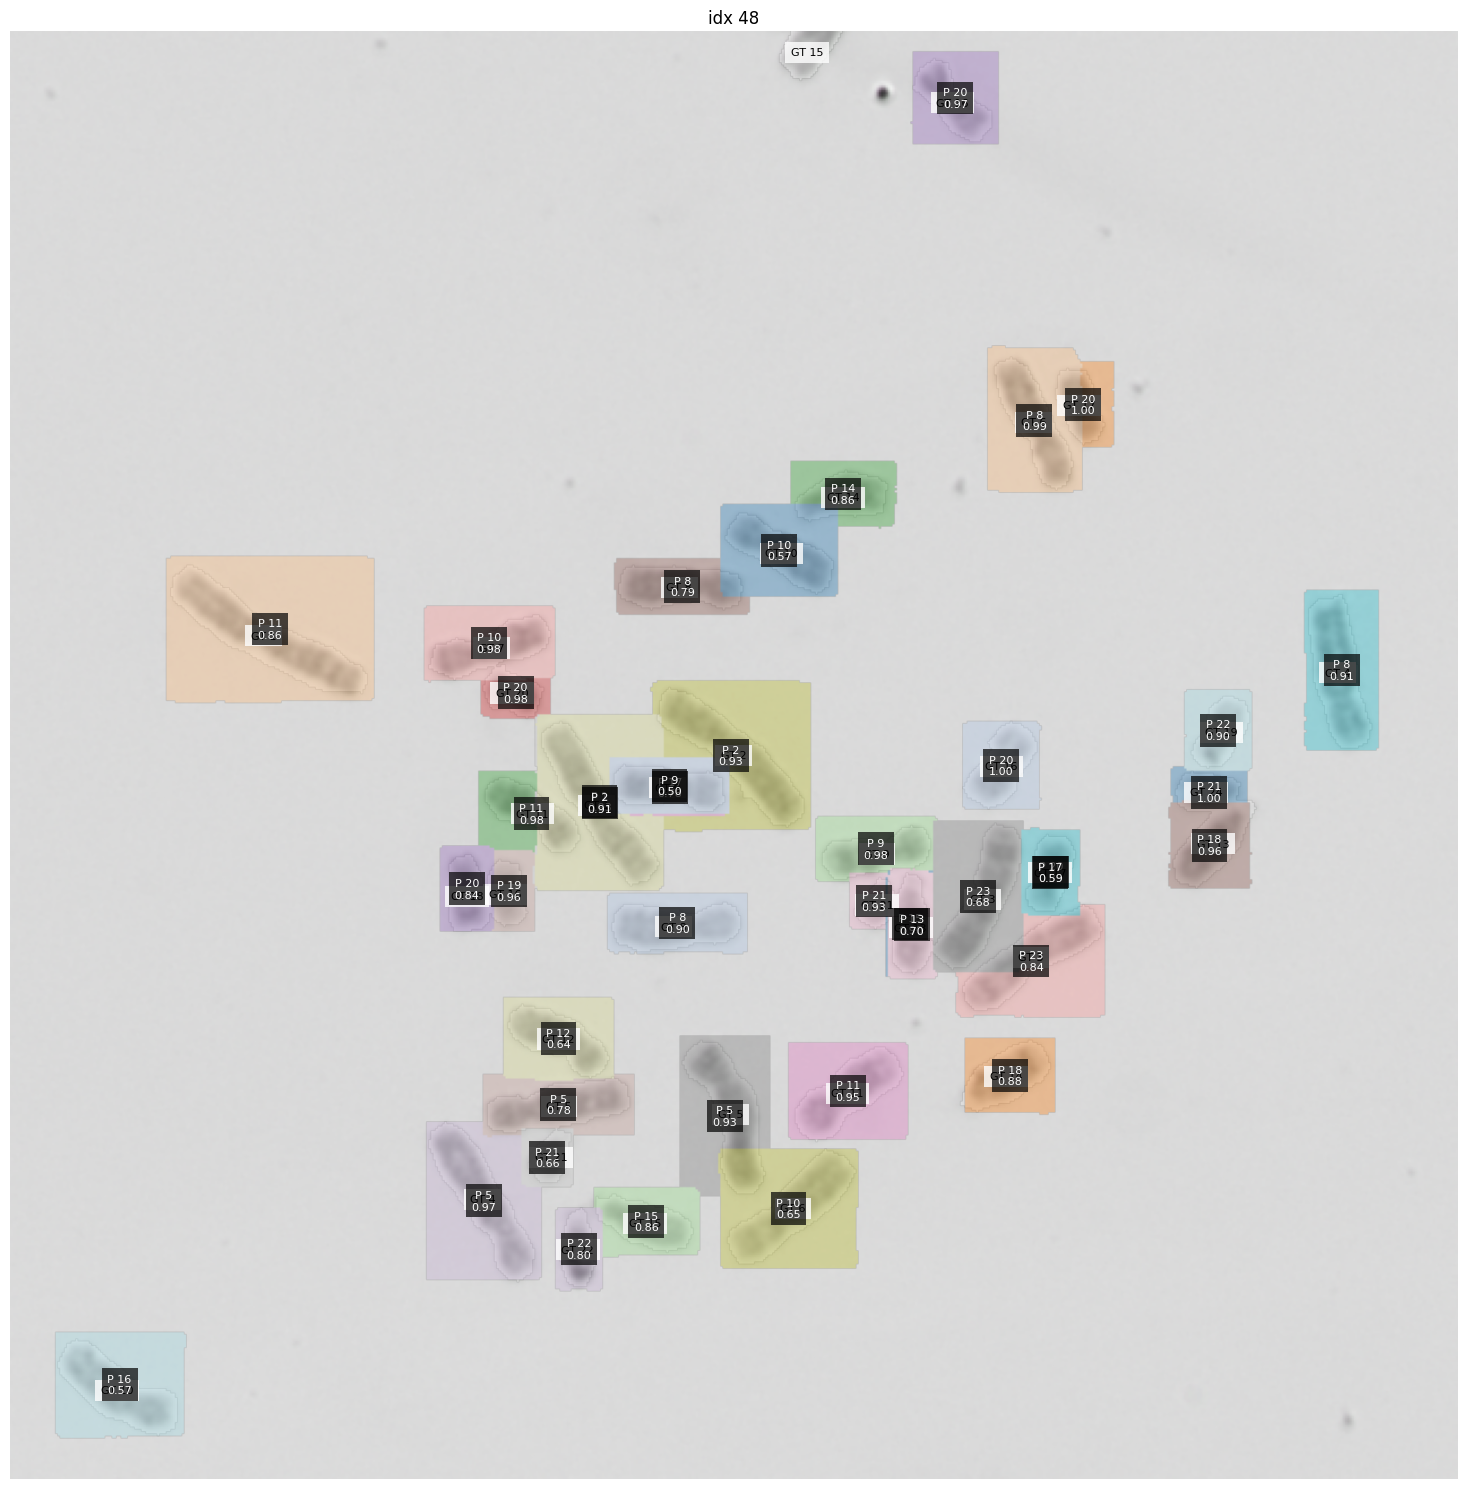

In [20]:
import matplotlib.pyplot as plt
ds_b_test = DatasetB(cfg.root_b, "test", cfg.label_map, cfg.max_size)

plot_B_predictions(ds_b_test, model, device, n=1, score_thresh=0.5)

In [14]:
torch.save(model.state_dict(), "maskrcnn_karyo_test.pth")